In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from LSTM import *
from LSTMbis import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time

import pdb

torch.manual_seed(1)

In [2]:
import os
data = {}
a=0
for j in range(1,4):
    for i in os.listdir('./data_linear_augm/%s'%j):
        if i.endswith('.txt'):
            a = a+1
            data['%s'%a] = pd.read_csv('data_linear_augm/{}/{}'.format(j,i), header = None, 
                                        names = ['frameNb','id', 'x','y','Vx','Vy'],
                                           delimiter=' ')

In [5]:
a = 0
inputs = np.zeros([len(data),14,2])
gt = np.zeros([len(data),6,2])
in_coord = np.zeros([len(data),14,2])
gt_coord = np.zeros([len(data),7,2])

for i in data:
    inputs[a,:,:] = np.array(data['%s'%i].loc[0:13,['Vx','Vy']])
    gt[a,:,:] = np.array(data['%s'%i].loc[14:19,['Vx','Vy']])
    in_coord[a,:,:] = np.array(data['%s'%i].loc[0:13,['x','y']])
    gt_coord[a,:,:] = np.array(data['%s'%i].loc[13:19,['x','y']])
    a +=1

In [9]:
mask = list(range(len(inputs)-100, len(inputs)))
x_val = inputs[mask]
y_val = gt[mask]
mask = list(range(len(inputs)-100))
x_train = inputs[mask]
y_train = gt[mask]

x_train,y_train = torch.from_numpy(x_train).type(torch.FloatTensor), torch.from_numpy(y_train).type(torch.FloatTensor)
x_val,y_val = torch.from_numpy(x_val).type(torch.FloatTensor), torch.from_numpy(y_val).type(torch.FloatTensor)

x_train = x_train.unsqueeze(1) # add 1 dimension to the training set
y_train = y_train.unsqueeze(1) # add 1 dimension to the training set
x_val = x_val.unsqueeze(1) # add 1 dimension to the validation set
y_val = y_val.unsqueeze(1) # add 1 dimension to the validation set

print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)

traindataset = utils.TensorDataset(x_train, y_train)
trainloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

valdataset = utils.TensorDataset(x_val, y_val)
valloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

Train data shape:  torch.Size([2363, 1, 14, 2])
Train labels shape:  torch.Size([2363, 1, 6, 2])
Validation data shape:  torch.Size([100, 1, 14, 2])
Validation labels shape:  torch.Size([100, 1, 6, 2])


In [10]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=1, n_output=None):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        
        self.conv1 = nn.Conv2d(n_input_channels,3,5,padding=2)
        self.conv1_bn = nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
     
        self.fc1 = nn.Linear(14*2 * 3, 6*2 * 1)
        
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Variable `x` with `x.view`.                                                  #
        ################################################################################
        
        
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = x.view(-1, 14*2 * 3) # in order to reshape the tensor for as many columns we need
        x = self.fc1(x)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def predict(self, x):
        return self.forward(x)

In [12]:
net = ConvNet()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)
epochs = 100
steps = 0
running_loss = 0
print_every = 100
vec_acc_ = np.zeros(epochs*25)
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Do not forget to transform the inputs and outputs into Variable        #
        # which pytorch uses.                                                          #
        ################################################################################
        inp = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        output = net.forward(inp)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        loss = criterion(output, targets)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
        grad = loss.backward()
        optimizer.step()
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            sum_accuracy = 0
            for ii, (images, labels) in enumerate(valloader):
                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                
                inp = Variable(images)
                targets = Variable(labels)
                predicted = net.predict(inp)
                accuracy = criterion(predicted, targets)
                accuracy = accuracy.data.numpy().tolist()[0]
                #vec_acc_[steps-1] = accuracy/(ii+1)
                sum_accuracy += accuracy
                
                #inputs = Variable(images, volatile=True)
                #predicted = net.predict(inputs)
                #equality = (labels == predicted.max(1)[1])
                #accuracy += equality.type_as(torch.FloatTensor()).mean()
                
                
                #im = Variable(images)
                #out = net.predict(im)
                #_,prediction = torch.max(out, 1)
                #pred_y = prediction.data.numpy().squeeze()
                #target_y = labels.numpy()
                #accuracy = np.mean(predicted == inputs)
                #print(pred_y.shape,target_y.shape)
                
                
                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################
            
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(loss.data[0]),
                  "Test accuracy: {:.4f}..".format(sum_accuracy/(ii+1)),
                  "{:.4f} s/batch ".format((stop - start)/print_every),
                  "steps {:.4f}".format(steps)
                 )
            running_loss = 0
            start = time.time()

#plt.plot(range(epochs*25),vec_acc_)
#plt.show()

Epoch: 1/100.. Loss: 0.1630.. Test accuracy: 0.1635.. 0.0005 s/batch  steps 100.0000
Epoch: 1/100.. Loss: 0.1817.. Test accuracy: 0.1320.. 0.0005 s/batch  steps 200.0000
Epoch: 1/100.. Loss: 0.2086.. Test accuracy: 0.1199.. 0.0005 s/batch  steps 300.0000
Epoch: 1/100.. Loss: 0.0645.. Test accuracy: 0.1125.. 0.0005 s/batch  steps 400.0000
Epoch: 2/100.. Loss: 0.1593.. Test accuracy: 0.1096.. 0.0002 s/batch  steps 500.0000
Epoch: 2/100.. Loss: 0.1800.. Test accuracy: 0.1040.. 0.0005 s/batch  steps 600.0000
Epoch: 2/100.. Loss: 0.1087.. Test accuracy: 0.1001.. 0.0005 s/batch  steps 700.0000
Epoch: 2/100.. Loss: 0.0866.. Test accuracy: 0.0994.. 0.0005 s/batch  steps 800.0000
Epoch: 2/100.. Loss: 0.0320.. Test accuracy: 0.0957.. 0.0005 s/batch  steps 900.0000
Epoch: 3/100.. Loss: 0.0588.. Test accuracy: 0.0917.. 0.0002 s/batch  steps 1000.0000
Epoch: 3/100.. Loss: 0.1828.. Test accuracy: 0.0885.. 0.0005 s/batch  steps 1100.0000
Epoch: 3/100.. Loss: 0.0741.. Test accuracy: 0.0858.. 0.0005 s/

Epoch: 21/100.. Loss: 0.0249.. Test accuracy: 0.0536.. 0.0005 s/batch  steps 9600.0000
Epoch: 21/100.. Loss: 0.0632.. Test accuracy: 0.0537.. 0.0005 s/batch  steps 9700.0000
Epoch: 21/100.. Loss: 0.0202.. Test accuracy: 0.0542.. 0.0005 s/batch  steps 9800.0000
Epoch: 21/100.. Loss: 0.0304.. Test accuracy: 0.0530.. 0.0005 s/batch  steps 9900.0000
Epoch: 22/100.. Loss: 0.1008.. Test accuracy: 0.0536.. 0.0003 s/batch  steps 10000.0000
Epoch: 22/100.. Loss: 0.0316.. Test accuracy: 0.0546.. 0.0005 s/batch  steps 10100.0000
Epoch: 22/100.. Loss: 0.0297.. Test accuracy: 0.0541.. 0.0005 s/batch  steps 10200.0000
Epoch: 22/100.. Loss: 0.0704.. Test accuracy: 0.0540.. 0.0005 s/batch  steps 10300.0000
Epoch: 22/100.. Loss: 0.0809.. Test accuracy: 0.0527.. 0.0005 s/batch  steps 10400.0000
Epoch: 23/100.. Loss: 0.1267.. Test accuracy: 0.0530.. 0.0005 s/batch  steps 10500.0000
Epoch: 23/100.. Loss: 0.0512.. Test accuracy: 0.0537.. 0.0006 s/batch  steps 10600.0000
Epoch: 23/100.. Loss: 0.0727.. Test 

Epoch: 41/100.. Loss: 0.0128.. Test accuracy: 0.0486.. 0.0006 s/batch  steps 19000.0000
Epoch: 41/100.. Loss: 0.0400.. Test accuracy: 0.0493.. 0.0007 s/batch  steps 19100.0000
Epoch: 41/100.. Loss: 0.0942.. Test accuracy: 0.0499.. 0.0006 s/batch  steps 19200.0000
Epoch: 41/100.. Loss: 0.0487.. Test accuracy: 0.0502.. 0.0008 s/batch  steps 19300.0000
Epoch: 42/100.. Loss: 0.0433.. Test accuracy: 0.0491.. 0.0000 s/batch  steps 19400.0000
Epoch: 42/100.. Loss: 0.0242.. Test accuracy: 0.0500.. 0.0007 s/batch  steps 19500.0000
Epoch: 42/100.. Loss: 0.1129.. Test accuracy: 0.0500.. 0.0007 s/batch  steps 19600.0000
Epoch: 42/100.. Loss: 0.0258.. Test accuracy: 0.0483.. 0.0005 s/batch  steps 19700.0000
Epoch: 42/100.. Loss: 0.0462.. Test accuracy: 0.0482.. 0.0006 s/batch  steps 19800.0000
Epoch: 43/100.. Loss: 0.0385.. Test accuracy: 0.0505.. 0.0002 s/batch  steps 19900.0000
Epoch: 43/100.. Loss: 0.0830.. Test accuracy: 0.0482.. 0.0005 s/batch  steps 20000.0000
Epoch: 43/100.. Loss: 0.0174.. T

Epoch: 61/100.. Loss: 0.0255.. Test accuracy: 0.0492.. 0.0001 s/batch  steps 28400.0000
Epoch: 61/100.. Loss: 0.0195.. Test accuracy: 0.0488.. 0.0006 s/batch  steps 28500.0000
Epoch: 61/100.. Loss: 0.0510.. Test accuracy: 0.0488.. 0.0005 s/batch  steps 28600.0000
Epoch: 61/100.. Loss: 0.0383.. Test accuracy: 0.0476.. 0.0005 s/batch  steps 28700.0000
Epoch: 61/100.. Loss: 0.0681.. Test accuracy: 0.0486.. 0.0008 s/batch  steps 28800.0000
Epoch: 62/100.. Loss: 0.0214.. Test accuracy: 0.0488.. 0.0002 s/batch  steps 28900.0000
Epoch: 62/100.. Loss: 0.0577.. Test accuracy: 0.0478.. 0.0005 s/batch  steps 29000.0000
Epoch: 62/100.. Loss: 0.0207.. Test accuracy: 0.0488.. 0.0006 s/batch  steps 29100.0000
Epoch: 62/100.. Loss: 0.0231.. Test accuracy: 0.0484.. 0.0005 s/batch  steps 29200.0000
Epoch: 62/100.. Loss: 0.0426.. Test accuracy: 0.0481.. 0.0005 s/batch  steps 29300.0000
Epoch: 63/100.. Loss: 0.0363.. Test accuracy: 0.0470.. 0.0004 s/batch  steps 29400.0000
Epoch: 63/100.. Loss: 0.0256.. T

Epoch: 80/100.. Loss: 0.0702.. Test accuracy: 0.0477.. 0.0006 s/batch  steps 37800.0000
Epoch: 81/100.. Loss: 0.0698.. Test accuracy: 0.0477.. 0.0003 s/batch  steps 37900.0000
Epoch: 81/100.. Loss: 0.0388.. Test accuracy: 0.0489.. 0.0005 s/batch  steps 38000.0000
Epoch: 81/100.. Loss: 0.0481.. Test accuracy: 0.0485.. 0.0005 s/batch  steps 38100.0000
Epoch: 81/100.. Loss: 0.0826.. Test accuracy: 0.0473.. 0.0006 s/batch  steps 38200.0000
Epoch: 81/100.. Loss: 0.0359.. Test accuracy: 0.0473.. 0.0005 s/batch  steps 38300.0000
Epoch: 82/100.. Loss: 0.0769.. Test accuracy: 0.0465.. 0.0005 s/batch  steps 38400.0000
Epoch: 82/100.. Loss: 0.0342.. Test accuracy: 0.0473.. 0.0005 s/batch  steps 38500.0000
Epoch: 82/100.. Loss: 0.0393.. Test accuracy: 0.0468.. 0.0005 s/batch  steps 38600.0000
Epoch: 82/100.. Loss: 0.0479.. Test accuracy: 0.0470.. 0.0005 s/batch  steps 38700.0000
Epoch: 83/100.. Loss: 0.0219.. Test accuracy: 0.0467.. 0.0001 s/batch  steps 38800.0000
Epoch: 83/100.. Loss: 0.0160.. T

Epoch: 100/100.. Loss: 0.0523.. Test accuracy: 0.0477.. 0.0008 s/batch  steps 47200.0000
Epoch: 100/100.. Loss: 0.0725.. Test accuracy: 0.0472.. 0.0010 s/batch  steps 47300.0000


In [15]:
output_final = net.predict(Variable(x_train))
output_final = output_final.data.numpy()
print(output_final.shape)
output_final = np.reshape(output_final,(2363,6,2))
output_final.shape

(2363, 12)


(2363, 6, 2)

In [21]:
output_coord=np.zeros([len(output_final),7,2])
for j in range(7):
    for i in range(len(output_final)):
        if j==0:
            output_coord[i,j,:] = in_coord[i,13,:]
        else:
            output_coord[i,j,:] = output_coord[i,j-1,:]+output_final[i,j-1,:]*0.4


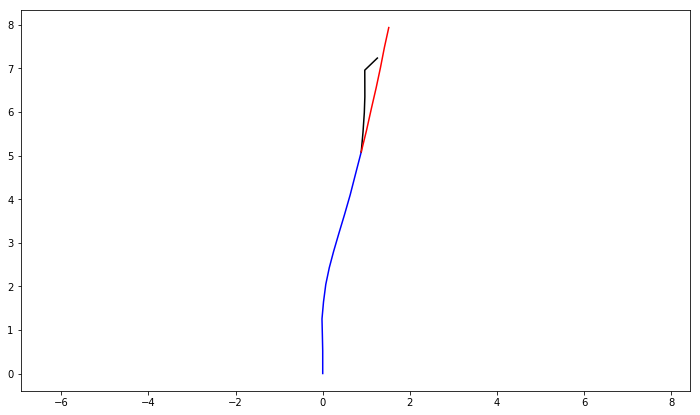

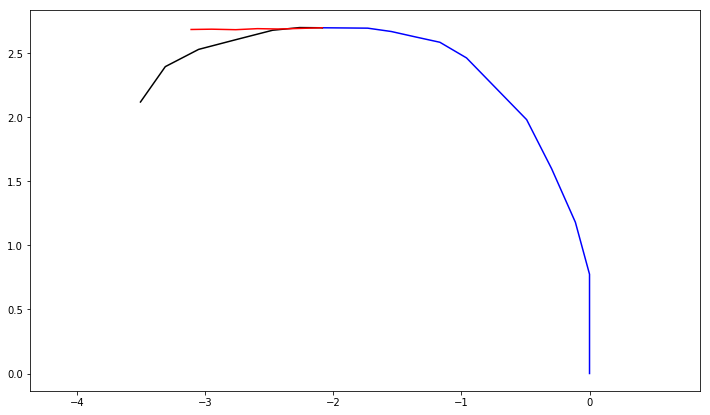

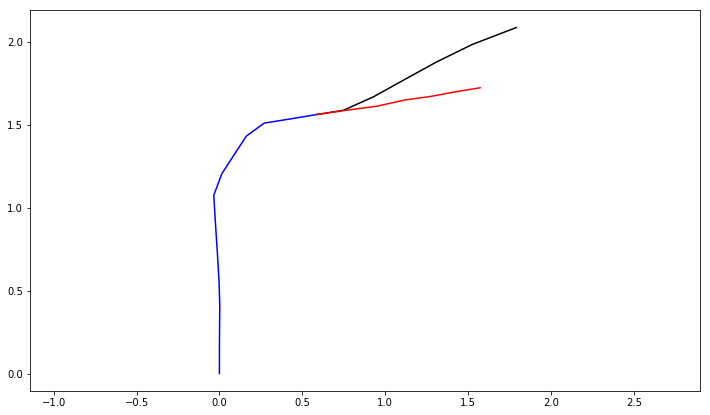

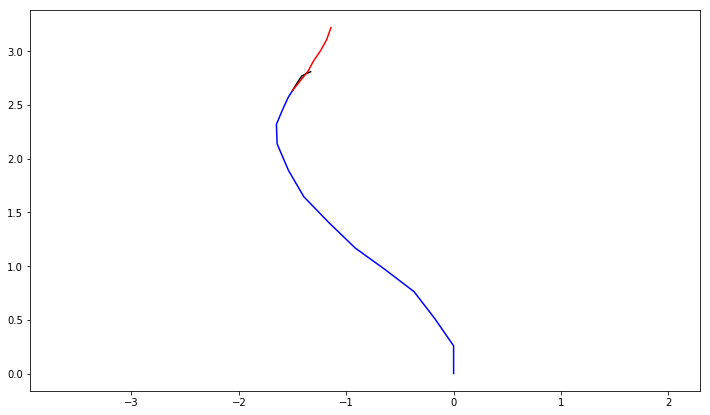

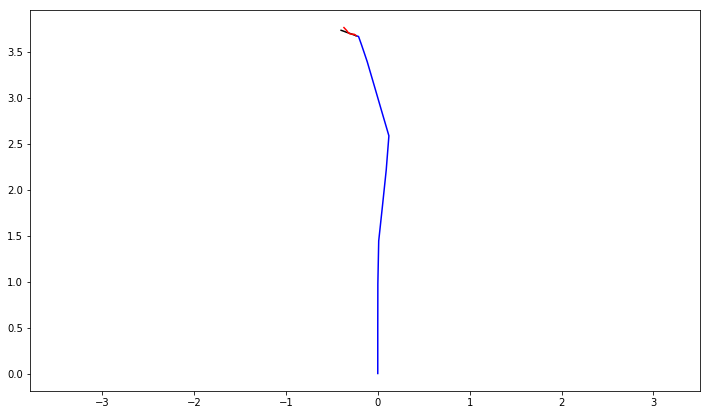

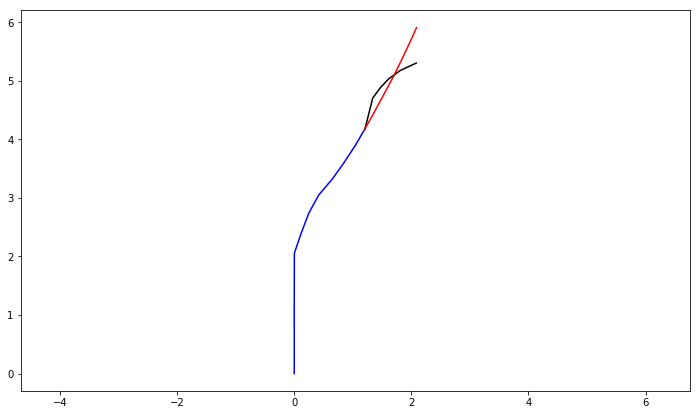

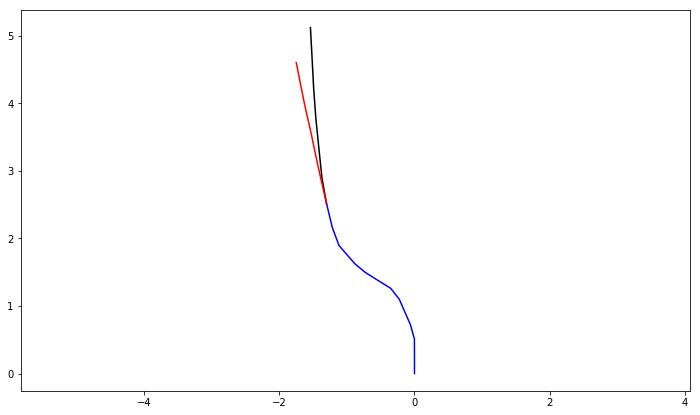

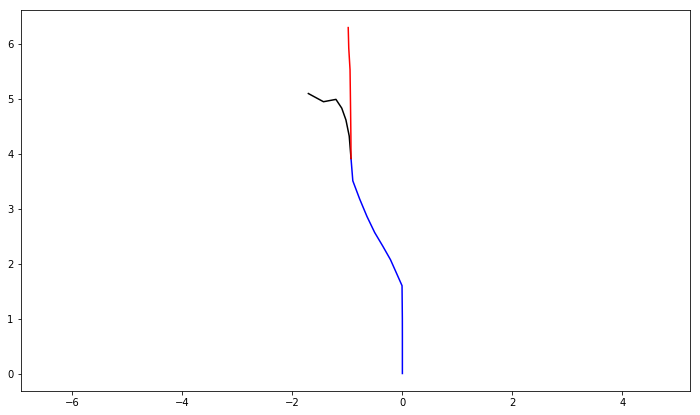

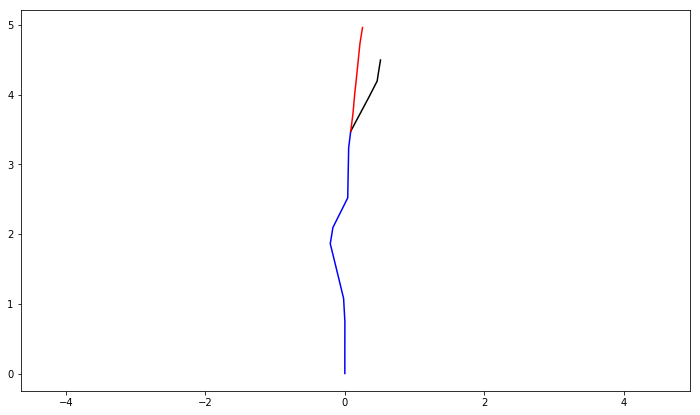

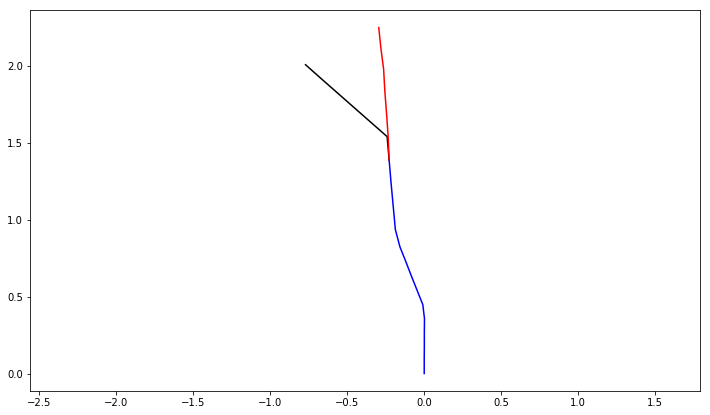

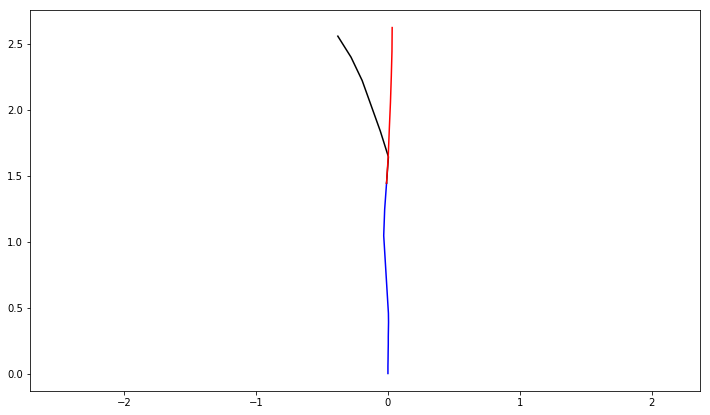

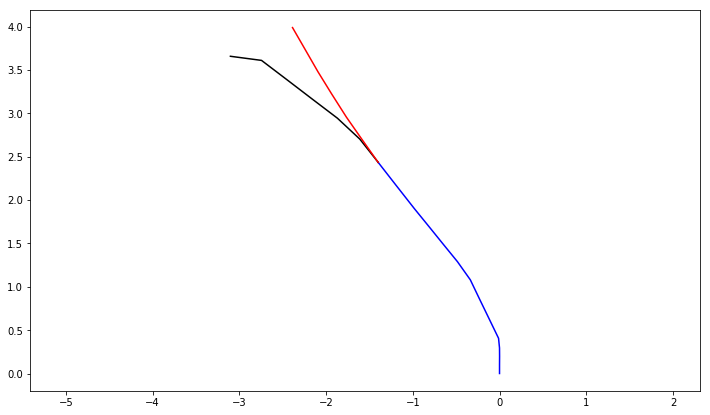

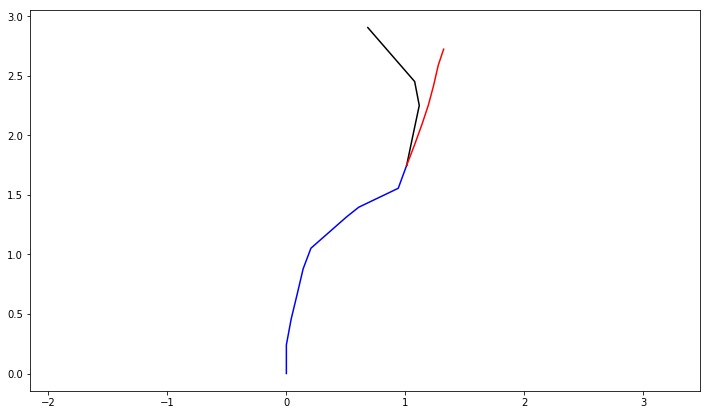

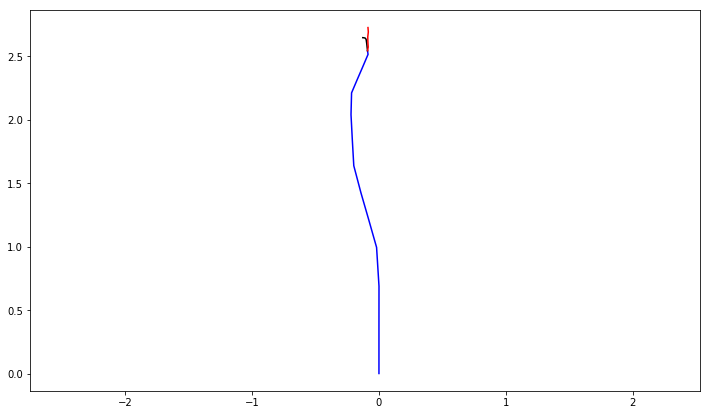

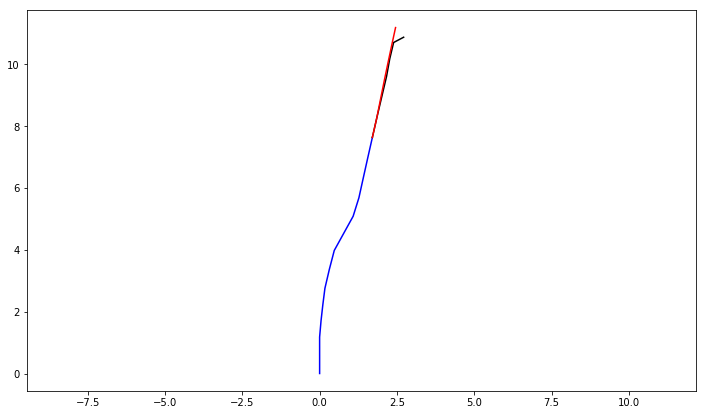

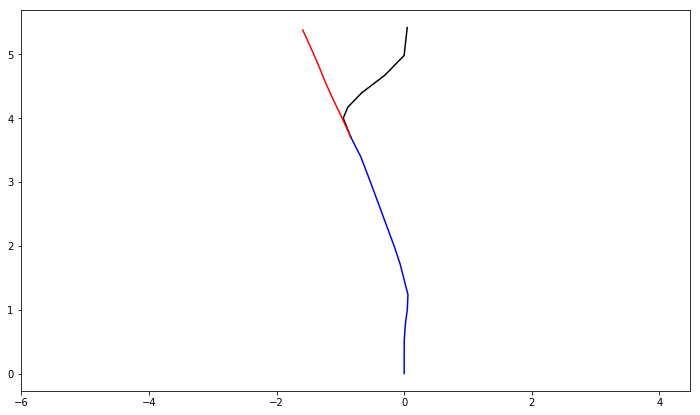

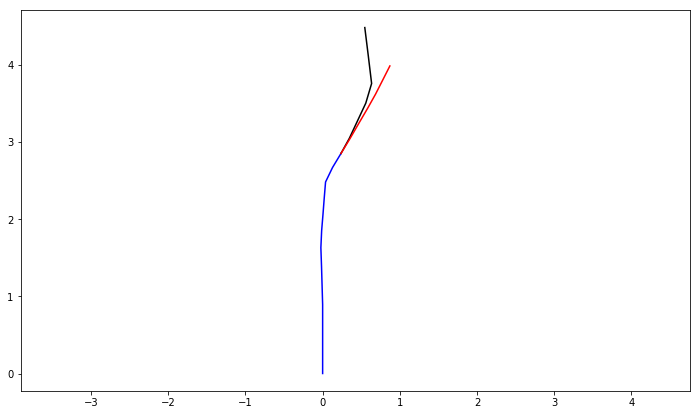

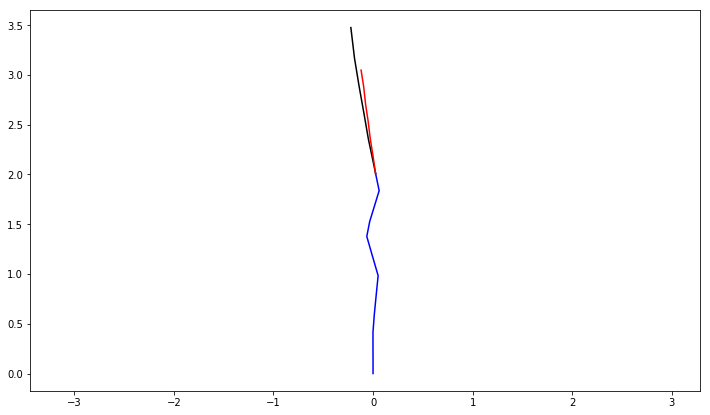

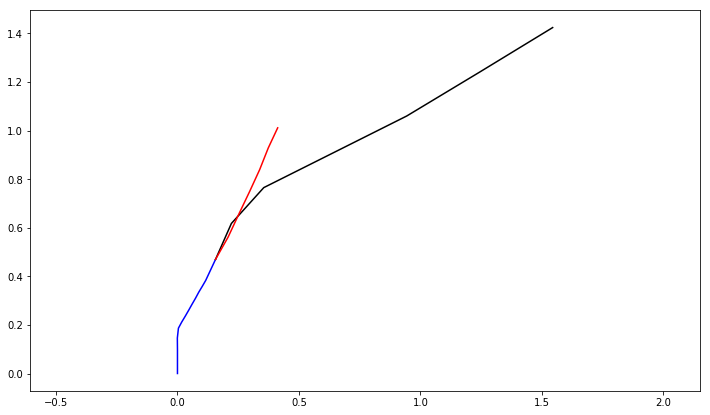

IndexError: index 2380 is out of bounds for axis 0 with size 2363

In [22]:
for i in range(20):
    plt.figure(figsize=(12, 7))

    plt.plot(in_coord[(i*20)+2000,:,0],in_coord[(i*20)+2000,:,1],c='b')
    plt.plot(gt_coord[(i*20)+2000,:,0],gt_coord[(i*20)+2000,:,1],c='k')
    plt.plot(output_coord[(i*20)+2000,:,0],output_coord[(i*20)+2000,:,1],c='r')
    plt.axis('equal')
    plt.show()